In [1]:
import autograd.numpy as np
from autograd import grad
import nlopt, numpy as npf
import matplotlib.pyplot as plt

import sys
sys.path.append('../')

import use_autograd
use_autograd.use = 1
import rcwa
from utils import test_grad

In [2]:
t = 59e-9
Period = 2e-6

c0 = 299792458
rho = 2.329e3
mp = 1e-4;
I = 1e10;
A = 10
vf = 0.2*c0
lam0 = 1.2e-6

N = 20
v = np.linspace(0,vf,N)
freq_list = np.sqrt((c0-v)/(c0+v))
gamma = 1./np.sqrt(1-(v/c0)**2)

Nx = 50
Ny = 50

In [3]:
nG = 101
# lattice vector
Lx = Period/lam0
Ly = Period/lam0
L1 = [Lx,0.]
L2 = [0.,Ly]

# frequency and angles
theta = 0.
phi = 0.

# now consider three layers: vacuum + patterned + vacuum
epsuniform1 = 1.
epsdiff = 11.3
epsbkg = 1
epsuniform3 = 1.

thick1 = 1.
thick2 = t/lam0
thick3 = 1.

In [4]:
ctrl = 0
vec = []
def fun_Distance(dof,Qabs):
    mT = mp + t*A*rho*np.mean(dof)

    R = np.array([])
    for freq in freq_list:
        freqcmp = freq*(1+1j/2/Qabs)
        obj = rcwa.RCWA_obj(nG,L1,L2,freqcmp,theta,phi,verbose=0)
        obj.Add_LayerUniform(thick1,epsuniform1)
        obj.Add_LayerGrid(thick2,epsdiff,epsbkg,Nx,Ny)
        obj.Add_LayerUniform(thick3,epsuniform3)
        obj.Init_Setup(Gmethod=0)

        # planewave excitation
        p_amp = 0.
        s_amp = 1.
        p_phase = 0.
        s_phase = 0.
        
        obj.MakeExcitationPlanewave(p_amp,p_phase,s_amp,s_phase,order = 0)
        obj.GridLayer_getDOF(dof)
        Rtmp1,_ = obj.RT_Solve()
        
        p_amp = 1.
        s_amp = 0.
        obj.MakeExcitationPlanewave(p_amp,p_phase,s_amp,s_phase,order = 0)
        Rtmp2,_ = obj.RT_Solve()

        R = np.append(R,(Rtmp1+Rtmp2)*0.5)

    integrand = mT/R*gamma*v/(1-v/c0)**2
    #D = c0/2/I/A*np.trapz(integrand,x=v)/1e9
    D = c0/2/I/A*(np.sum(integrand)-integrand[0]/2-integrand[-1]/2)*(v[1]-v[0])/1e9

    if 'autograd' not in str(type(D)):
        global ctrl
        global vec
        vec = npf.copy(dof)
        
        print ctrl,np.mean(R),D
        if npf.mod(ctrl,10)==0:
            plt.figure();
            plt.imshow(np.reshape(dof,(Nx,Ny)))
            plt.colorbar()
            plt.show()
            
        ctrl +=1
    return D

# Qabs = 20

0 0.2528691355398042 11.894463943331848


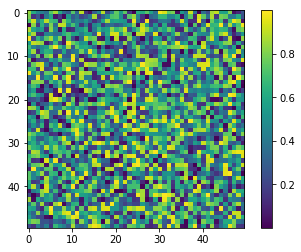

1 0.2533909169071993 11.88672388485642
2 0.2583624096089866 11.815232770941764
3 0.3032721138637072 11.332617926217997
4 0.39143478539036564 11.207414479082685
5 0.3560606055303994 11.166940451352252
6 0.35095786823786174 11.034635792053827
7 0.3429997328681419 10.229782774718425
8 0.1733646175838866 13.475636427444531
9 0.29029790559106355 10.34850240334278
10 0.35226911511163994 9.686251048281484


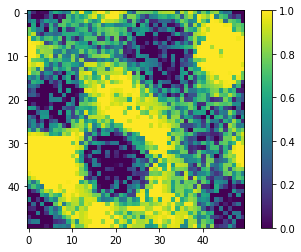

11 0.4033661615607153 8.45415005941911
12 0.4035616304186524 8.023742783018301
13 0.41776777050927444 7.80095879977254
14 0.4172937862550656 7.673370751265504
15 0.4183398148641991 7.6361373810123165
16 0.41800389084601025 7.61217977672214
17 0.41615933214277756 7.586437947222796
18 0.4138975282711205 7.563843064551572
19 0.4117628209509211 7.54459510576771
20 0.4105590990312608 7.519603798750799


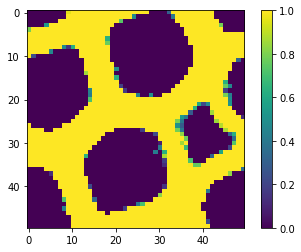

21 0.40808314098971515 7.477907580080331
22 0.4072809593955079 7.423138791767579
23 0.4034539999035508 7.336447653717654
24 0.39968606701304144 7.205402240013287
25 0.36203248899655394 7.608422377582038
26 0.37351399137437863 7.444101881291233
27 0.3923356272447286 7.202992055880393
28 0.3961881680116165 7.101930474315571
29 0.3925330309449067 7.017216669505497
30 0.3919122602668966 6.897562713818847


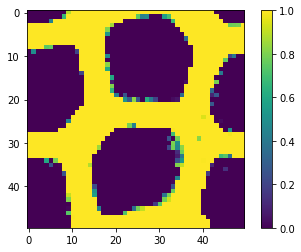

31 0.39020620084076907 6.831118163859639
32 0.38957310200662193 6.779765600022678


KeyboardInterrupt: 

In [5]:
Qabs = 20.
fun = lambda dof: fun_Distance(dof,Qabs)
grad_fun = grad(fun)
def fun_nlopt(dof,gradn):
    gradn[:] = grad_fun(dof)
    return fun(dof)

ndof = Nx*Ny
#init = np.ones(ndof)
init = np.random.random(ndof)
lb=np.zeros(ndof,dtype=float)
ub=np.ones(ndof,dtype=float)

opt = nlopt.opt(nlopt.LD_MMA, ndof)
opt.set_lower_bounds(lb)
opt.set_upper_bounds(ub)

opt.set_xtol_rel(1e-5)
opt.set_maxeval(100)

opt.set_min_objective(fun_nlopt)
x = opt.optimize(init)

# Qabs = 100

64 0.5946765302733221 4.5223700579267945
65 0.594672467522259 4.5223542384619675
66 0.5946321909624537 4.522198363503772
67 0.594119118612513 4.520377477263142
68 0.5908556524810528 4.5146640315120505
69 0.5903685945305991 4.5117091076737985
70 0.5888852309933228 4.508587107531279


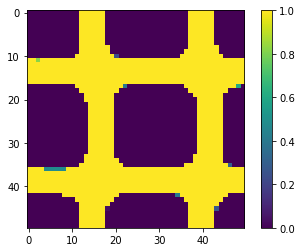

71 0.5906080048230191 4.508355242224204
72 0.5887582666645506 4.506114089266576
73 0.5914647259881535 4.507720311370663
74 0.5900767996860427 4.505692501010799
75 0.5890497539926401 4.50503109123412
76 0.5892647535891999 4.504920454286119
77 0.589219371790105 4.504772859450176
78 0.5901520660051904 4.505014413244338
79 0.5895519431056238 4.504696400794255
80 0.5891411706907081 4.5046513581792995


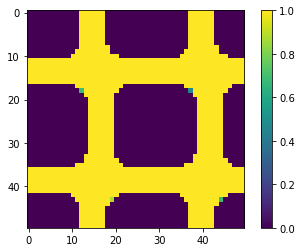

KeyboardInterrupt: 

In [21]:
Qabs = 100.
fun = lambda dof: fun_Distance(dof,Qabs)
grad_fun = grad(fun)
def fun_nlopt(dof,gradn):
    gradn[:] = grad_fun(dof)
    return fun(dof)

ndof = Nx*Ny
#init = np.ones(ndof)
init = npf.copy(vec)
lb=np.zeros(ndof,dtype=float)
ub=np.ones(ndof,dtype=float)

opt = nlopt.opt(nlopt.LD_MMA, ndof)
opt.set_lower_bounds(lb)
opt.set_upper_bounds(ub)

opt.set_xtol_rel(1e-5)
opt.set_maxeval(100)

opt.set_min_objective(fun_nlopt)
x = opt.optimize(init)

# Qabs = 1000

In [22]:
Qabs = 1000
fun = lambda dof: fun_Distance(dof,Qabs)
grad_fun = grad(fun)
def fun_nlopt(dof,gradn):
    gradn[:] = grad_fun(dof)
    return fun(dof)

ndof = Nx*Ny
#init = np.ones(ndof)
init = npf.copy(vec)
lb=np.zeros(ndof,dtype=float)
ub=np.ones(ndof,dtype=float)

opt = nlopt.opt(nlopt.LD_MMA, ndof)
opt.set_lower_bounds(lb)
opt.set_upper_bounds(ub)

opt.set_xtol_rel(1e-5)
opt.set_maxeval(100)

opt.set_min_objective(fun_nlopt)
x = opt.optimize(init)

81 0.6528685308859461 4.151913921970556
82 0.6528685311872963 4.1519139218424925


# Qabs = Inf

In [6]:
Qabs = np.inf
fun = lambda dof: fun_Distance(dof,Qabs)
grad_fun = grad(fun)
def fun_nlopt(dof,gradn):
    gradn[:] = grad_fun(dof)
    return fun(dof)

ndof = Nx*Ny
#init = np.ones(ndof)
init = npf.copy(vec)
lb=np.zeros(ndof,dtype=float)
ub=np.ones(ndof,dtype=float)

opt = nlopt.opt(nlopt.LD_MMA, ndof)
opt.set_lower_bounds(lb)
opt.set_upper_bounds(ub)

opt.set_xtol_rel(1e-5)
opt.set_maxeval(100)

opt.set_min_objective(fun_nlopt)
x = opt.optimize(init)

33 0.6387663134462559 4.455147454334113
34 0.6387770178509581 4.455038094455152


KeyboardInterrupt: 